# Preprocess data

In [1]:
import numpy as np

In [2]:
from typing import TYPE_CHECKING, Tuple, Union, Optional
from pathlib import Path

if TYPE_CHECKING:
    import numpy.typing as npt

import h5py  # type: ignore[import]
import numpy as np
from scipy.sparse import coo_matrix  # type: ignore[import]
from tqdm import tqdm

PathLike = Union[Path, str]


def sparse_to_dense(
    h5_file: PathLike,
    dataset_name: str,
    initial_shape: Tuple[int, int],
    final_shape: Union[Tuple[int, int, int], Tuple[int, int]],
    values_dataset_name: Optional[str] = None,
) -> "npt.ArrayLike":
    """Convert sparse COO formatted contact maps to dense.

    Parameters
    ----------
    h5_file : PathLike
        The HDF5 file containing contact maps.
    dataset_name : str
        The dataset name containing the contact map indices.
    initial_shape : Tuple[int, int]
        The shape of the contact map saved in the HDF5 file.
    final_shape : Union[Tuple[int, int, int], Tuple[int, int]]
        The final shape of the contact map incase adding an extra
        dimension is necessary e.g. (D, D, 1) where D is the number
        of residues or the cropping shape.
    values_dataset_name: Optional[str], default=None
        Name of dataset containing the values of the sparse matrix.
        By default, it autofills with 1.

    Returns
    -------
    npt.ArrayLike
        The output array of contact maps of shape (N, D, D) or
        (N, D, D, 1) depending on :obj:`final_shape` where N is
        the number of contact maps in the HDF5 file.
    """
    contact_maps = []
    with h5py.File(h5_file, "r", libver="latest", swmr=False) as f:
        
        # Read all data into memory at once
        dataset = f[dataset_name][...]
        if values_dataset_name is not None:
            values_dataset = f[values_dataset_name][...]
        
        for i, raw_indices in tqdm(enumerate(dataset)):
            indices = raw_indices.reshape((2, -1)).astype("int16")
            
            if values_dataset_name is None:
                # Contact matrices are binary so we don't need to store the values
                # in HDF5 format. Instead we create a vector of 1s on the fly.
                values = np.ones(indices.shape[1]).astype("byte")
            else:
                values = values_dataset[i]

            # Construct COO formated sparse matrix
            contact_map = coo_matrix(
                (values, (indices[0], indices[1])), shape=initial_shape
            ).todense()
            # Crop and reshape incase of extra 1 e.g. (N, N, 1)
            contact_map = np.array(
                contact_map[: final_shape[0], : final_shape[1]], dtype=np.float16
            ).reshape(final_shape)
            contact_maps.append(contact_map)
    return np.array(contact_maps)

In [ ]:
!ls /lambda_stor/homes/abrace/data/bba/

In [ ]:
contact_maps = sparse_to_dense(
    h5_file="/lambda_stor/homes/abrace/data/bba/1FME-0.h5",
    dataset_name="contact_map",
    initial_shape=(28, 28),
    final_shape=(28, 28),
    values_dataset_name="contact_map_values",
) 

In [ ]:
mask = np.ones((28, 28))
for i in range(28):
    try:
        mask[i][i+1] = 0
    except:
        pass
    try:
        mask[i][i-1] = 0
    except:
        pass
    try:
        mask[i][i+2] = 0
    except:
        pass
    try:
        mask[i][i-2] = 0
    except:
        pass

In [ ]:
mask[0][26] = 1
mask[0][27] = 1
mask[1][27] = 1

In [2]:
import matplotlib.pyplot as plt

In [3]:
%matplotlib widget

In [ ]:
plt.imshow(mask)

In [ ]:
masked_contact_maps = np.array([cm * mask for cm in contact_maps])

In [ ]:
def scale(cm):
    for i in range(28):
        for j in range(28):
            diff = abs(i-j)
            cm[i][j] *= diff
    return cm

In [ ]:
scaled_contact_maps = np.array([scale(cm) for cm in tqdm(contact_maps)])

In [ ]:
scaled_contact_maps = np.load('scaled_contact_maps.npy')

In [ ]:
plt.imshow(scaled_contact_maps[0].astype("float32"))

In [25]:
from pathlib import Path

In [26]:
data_paths = list(sorted(Path("/homes/abrace/src/fourier_neural_operator/data/preprocessed/bba").glob("*.npy")))

In [27]:
data = np.concatenate([np.load(p) for p in data_paths])

In [28]:
data.shape

(1114545, 28, 28)

In [59]:
traj = [x.sum() for x in data]

In [98]:
len(traj)

1114545

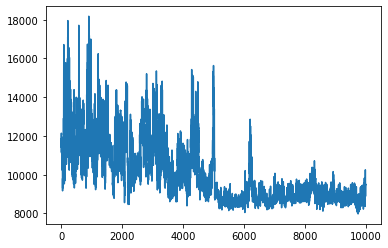

In [365]:
# x = 160000
x = 999000
plt.plot(range(10000), traj[(x-10000):x])
# f = plt.figure(figsize=(20,5))
# plt.plot(range(len(traj)), traj)
# plt.axvline(181000)

In [371]:
x = 143000
first_window = data[(x-10000):x]

In [372]:
x = 443000
second_window = data[(x-10000):x]

In [373]:
x = 809000
third_window = data[(x-10000):x]

In [374]:
x = 889000
fourth_window = data[(x-10000):x]

In [375]:
x = 999000
fifth_window = data[(x-10000):x]

In [376]:
samples = np.array([first_window, second_window, third_window, fourth_window, fifth_window])

In [377]:
np.save('folded_windows_10kframes.npy', samples)

In [4]:
samples = np.load('folded_windows_10kframes.npy')

In [5]:
samples.shape

(5, 10000, 28, 28)

In [24]:
from matplotlib.animation import FuncAnimation

In [30]:
anim.pause()

In [ ]:
plt.contourf(data[0])

In [31]:
fig = plt.figure()
ax = plt.axes(xlim=(0, 28), ylim=(0, 28))

def animate(i):
    ax.clear()
    ax.imshow(data[i].squeeze().astype("float32"))
    
anim = FuncAnimation(fig, animate, frames=1000, blit=False, interval=800, repeat=False)
plt.colorbar()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

In [46]:
data.shape

(1114545, 28, 28)

In [47]:
contact_maps = data

In [ ]:
contact_maps.shape

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.imshow(contact_maps[::1].astype("float32").reshape(28*28, -1), aspect='auto')

In [ ]:
# contact_maps = scaled_contact_maps

In [ ]:
!pip install sklearn

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from tqdm import tqdm

In [ ]:
normed = []
for x in tqdm(scaled_contact_maps):
    scaler = MinMaxScaler()
    normed_cm = scaler.fit_transform(x)
    normed.append(normed_cm)

In [ ]:
plt.imshow(scaled_contact_maps[0].astype("float32"))

In [ ]:
plt.imshow(normed[0].astype("float32"))

In [ ]:
contact_maps = np.array(normed)

In [ ]:
contact_maps.shape

In [48]:
# To input to FNO, the data must have shape (N, 28, 28, T)
# Pick T=50, to mimic the 2D Navier-Stokes equation example
# found here: https://github.com/zongyi-li/fourier_neural_operator/tree/master

T = 100 # Number of time steps per example
M = contact_maps.shape[1] # Number of residues
N = len(contact_maps) # Total number of contact maps

print(T, M, N)

100 28 1114545


In [49]:
fno_input = np.array([contact_maps[i * T: (i + 1) * T] for i in range(N // T)]).astype("float32")
fno_input = np.swapaxes(fno_input, 1, 3)
fno_input.shape

(11145, 28, 28, 100)

In [ ]:
# np.save("bba_fno_input.npy", fno_input)

In [ ]:
# fno_input = np.load("bba_fno_input.npy").astype("float32")
# fno_input.shape

In [ ]:
# Take Every other residue to get (N, 14, 14, 50)
# Then test super resolution on (N, 28, 28, 50)

# Then test time-super-resolution
# Train on: (N, 28, 28, 50)
# Test on: (N, 28, 28, 100)

# Train model

In [50]:
"""
@author: Zongyi Li
This file is the Fourier Neural Operator for 2D problem such as the Navier-Stokes equation discussed in Section 5.3 in the [paper](https://arxiv.org/pdf/2010.08895.pdf),
which uses a recurrent structure to propagates in time.
"""


import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from utilities3 import *

import operator
from functools import reduce
from functools import partial

from timeit import default_timer

from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)


################################################################
# fourier layer
################################################################

class SpectralConv2d_fast(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d_fast, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width, timesteps: int):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
        input shape: (batchsize, x=64, y=64, c=12)
        output: the solution of the next timestep
        output shape: (batchsize, x=64, y=64, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 2 # pad the domain if input is non-periodic
        #self.fc0 = nn.Linear(12, self.width)
        # +2 because the grid (we think)
        self.fc0 = nn.Linear(timesteps + 2, self.width)
        # input channel is 12: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)

        self.conv0 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.bn0 = torch.nn.BatchNorm2d(self.width)
        self.bn1 = torch.nn.BatchNorm2d(self.width)
        self.bn2 = torch.nn.BatchNorm2d(self.width)
        self.bn3 = torch.nn.BatchNorm2d(self.width)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        # x = F.pad(x, [0,self.padding, 0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        # x = x[..., :-self.padding, :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)



In [7]:
# fno_input = samples

In [8]:
# fno_input = np.swapaxes(fno_input, 1, 3).astype("float16")

In [9]:
# len(fno_input)

5

In [105]:
# ntrain = 17832
# ntest = 4457

modes = 12
width = 20 # 25 + 25, this also doesn't work

batch_size = 32
batch_size2 = 32

epochs = 100
learning_rate = 0.0001
scheduler_step = 100
scheduler_gamma = 0.5

sub = 1
S = 28
T_in = 50
T = 50
step = 1

In [87]:
fno_input.shape

(11145, 28, 28, 100)

In [88]:
train_split_ptc = 0.8
fno_input_train = fno_input[: int(train_split_ptc * len(fno_input))]
fno_input_test = fno_input[: int((1- train_split_ptc) * len(fno_input))]
print(fno_input_train.shape)
print(fno_input_test.shape)

(8916, 28, 28, 100)
(2228, 28, 28, 100)


In [12]:
# fno_input_train = fno_input[:4]
# fno_input_test = fno_input[4:]

In [40]:
fno_input_train.shape

(8916, 28, 28, 100)

In [41]:
fno_input_test.shape

(2228, 28, 28, 100)

In [54]:
ntrain = len(fno_input_train)
ntest = len(fno_input_test)

In [115]:
torch.set_num_threads(2)

In [106]:
train_a = fno_input_train[:ntrain,::sub,::sub,:T_in]
train_u = fno_input_train[:ntrain,::sub,::sub,T_in:T+T_in]

test_a = fno_input_test[-ntest:,::sub,::sub,:T_in]
test_u = fno_input_test[-ntest:,::sub,::sub,T_in:T+T_in]

print(train_a.shape)
print(train_u.shape)

print(test_a.shape)
print(test_u.shape)

assert (S == train_u.shape[-2])
assert (T == train_u.shape[-1])

train_a = torch.from_numpy(train_a)
train_u = torch.from_numpy(train_u)
test_a = torch.from_numpy(test_a)
test_u = torch.from_numpy(test_u)

train_dataset = torch.utils.data.TensorDataset(train_a, train_u)
test_dataset = torch.utils.data.TensorDataset(test_a, test_u)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2, prefetch_factor=4, pin_memory=True, persistent_workers=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=2, prefetch_factor=4, pin_memory=True, persistent_workers=True
)

(8916, 28, 28, 50)
(8916, 28, 28, 50)
(2228, 28, 28, 50)
(2228, 28, 28, 50)


In [110]:
len(train_loader)

278

In [111]:
len(fno_input_train)/batch_size

278.625

In [72]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [107]:
model = FNO2d(modes, modes, width, T_in).cuda()

In [108]:
print(model)

FNO2d(
  (fc0): Linear(in_features=52, out_features=20, bias=True)
  (conv0): SpectralConv2d_fast()
  (conv1): SpectralConv2d_fast()
  (conv2): SpectralConv2d_fast()
  (conv3): SpectralConv2d_fast()
  (w0): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  (w1): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  (w2): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  (w3): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  (bn0): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


In [100]:
print(count_params(model))
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

466517


In [101]:
import wandb

In [109]:
wandb.finish()

In [112]:
wandb.init(project="fourier_neural_operator", reinit=True)

In [113]:
myloss = LpLoss(size_average=False)
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2_step = 0
    train_l2_full = 0
    for xx, yy in train_loader:
        loss = 0
        xx = xx.to(device)
        yy = yy.to(device)

        for t in range(0, T, step):
            y = yy[..., t:t + step]
            im = model(xx)
            loss += myloss(im.reshape(batch_size, -1), y.reshape(batch_size, -1))

            if t == 0:
                pred = im
            else:
                pred = torch.cat((pred, im), -1)

            xx = torch.cat((xx[..., step:], im), dim=-1)

        train_l2_step += loss.item()
        l2_full = myloss(pred.reshape(batch_size, -1), yy.reshape(batch_size, -1))
        train_l2_full += l2_full.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    test_l2_step = 0
    test_l2_full = 0
    model.eval()
    with torch.no_grad():
        for xx, yy in test_loader:
            loss = 0
            xx = xx.to(device)
            yy = yy.to(device)

            for t in range(0, T, step):
                y = yy[..., t:t + step]
                im = model(xx)
                loss += myloss(im.reshape(batch_size, -1), y.reshape(batch_size, -1))

                if t == 0:
                    pred = im
                else:
                    pred = torch.cat((pred, im), -1)

                xx = torch.cat((xx[..., step:], im), dim=-1)

            test_l2_step += loss.item()
            test_l2_full += myloss(pred.reshape(batch_size, -1), yy.reshape(batch_size, -1)).item()

    t2 = default_timer()
#     scheduler.step()
    results_dir = {}
    results_dir['time'] = t2-t1
    results_dir['train_l2_step'] = train_l2_step / ntrain / (T / step)
    results_dir['train_l2_full'] = train_l2_full / ntrain
    results_dir['test_l2_step'] = test_l2_step / ntest / (T / step)
    results_dir['test_l2_full'] = test_l2_full / ntest
    wandb.log(results_dir)
    print(ep, t2 - t1, train_l2_step / ntrain / (T / step), train_l2_full / ntrain, test_l2_step / ntest / (T / step),
          test_l2_full / ntest)

0 115.19929793290794 1.0038752231110153 1.0038044614180046 0.9972029779458174 0.9971366878899894


KeyboardInterrupt: 

In [65]:
torch.cuda.empty_cache()

In [ ]:
# generate figure 1
# relative error wrt epoch (loss curve)

In [ ]:
# # distance values
# epoch_prints = """0 42.81092274095863 0.4937476319783255 0.49396123154487453 0.48304816554366725 0.48347714847584383
# 1 41.74038385390304 0.4777162232704899 0.47219856719149234 0.46731318668316696 0.448610972951607
# 2 41.10376914800145 0.45782351097219887 0.4461775643240448 0.44931102496774733 0.4416411898182678
# 3 42.039382281014696 0.4332405357994055 0.4304912185497806 0.42747499325148647 0.426015575289967
# 4 45.02936312719248 0.4182806662092727 0.42260830538216165 0.4194621127930783 0.42533674404870936
# 5 44.74461394106038 0.4127451915578384 0.42118305430491443 0.41579025751276083 0.42233645597701386
# 6 45.01867930404842 0.4097005712167732 0.42020176792957686 0.4129501061357135 0.4239311500705088
# 7 44.43967142398469 0.4075468456461698 0.4196401243522168 0.4122257912413058 0.4197785033221092
# 8 44.88021915103309 0.40621104976744754 0.41869536468724916 0.410547168604162 0.42362749777167585
# 9 43.28271347400732 0.40488185959581086 0.41826833636838795 0.4093319146847655 0.4232965819846896"""

In [ ]:
# from collections import defaultdict
# logs = defaultdict(list)
# for line in epoch_prints.split("\n"):
#     epoch, time, train_l2_step, train_l2_full, test_l2_step, test_l2_full = line.split()
#     logs["epoch"].append(int(epoch))
#     logs["time"].append(float(time))
#     logs["train_l2_step"].append(float(train_l2_step))
#     logs["train_l2_full"].append(float(train_l2_full))
#     logs["test_l2_step"].append(float(test_l2_step))
#     logs["test_l2_full"].append(float(test_l2_full))

In [ ]:
# import pandas as pd
# df = pd.DataFrame(logs)

In [ ]:
# df.plot(kind="line", x="epoch", y="time")

In [ ]:
# df.plot(kind="line", x="epoch", y=["train_l2_step", "test_l2_step"])

In [ ]:
# df.plot(kind="line", x="epoch", y=["train_l2_full", "test_l2_full"])

In [ ]:
preds = []
yy_s = []
def inference(model, test_loader, T: int, step: int, batch_size: int):
    model.eval()
    with torch.no_grad():
        for xx, yy in test_loader:
            loss = 0
            xx = xx.to(device)
            yy = yy.to(device)
            yy_s.append(yy)
            for t in range(0, T, step):
                y = yy[..., t:t + step]
#                 print(y.shape)
                im = model(xx)
                loss += myloss(im.reshape(batch_size, -1), y.reshape(batch_size, -1))

                if t == 0:
                    pred = im
                else:
                    pred = torch.cat((pred, im), -1)
#                     print(pred.shape)

                xx = torch.cat((xx[..., step:], im), dim=-1)
#                 print(xx.shape)
            preds.append(pred)
#             print(xx.shape)

In [ ]:
inference(model, test_loader, T, step, batch_size)

In [ ]:
len(test_loader)

In [ ]:
len(train_loader)

In [ ]:
frames[0].shape

In [ ]:
# wandb.log({"example": [wandb.Image(img.numpy()) for img in frames]})

In [ ]:
frames = np.dsplit(preds[0][0].cpu(), 50)

In [ ]:
plt.contourf(frames[0].squeeze())

In [ ]:
plt.imshow(frames[1].squeeze().numpy().astype("float32"))

In [ ]:
from matplotlib.animation import FuncAnimation

In [ ]:
frames1 = np.dsplit(preds[10][0].cpu(), 50)
fig1 = plt.figure()
ax1 = plt.axes(xlim=(0, 28), ylim=(0, 28))

def animate(i):
    ax1.clear()
    ax1.imshow(frames1[i].squeeze().numpy().astype("float32"))

anim1 = FuncAnimation(fig1, animate, frames=50, blit=False)
# anim.save('preds_slow_imshow.mp4', fps=5, extra_args=['-vcodec', 'libx264'])
plt.show()

In [ ]:
frames2 = np.dsplit(yy_s[10][0].cpu(), 50)
fig2 = plt.figure()
ax2 = plt.axes(xlim=(0, 28), ylim=(0, 28))

def animate2(i):
    ax2.clear()
    ax2.imshow(frames2[i].squeeze().numpy().astype("float32"))

anim2 = FuncAnimation(fig2, animate2, frames=50, blit=False)
anim2.save('labels_slow_imshow.mp4', fps=5, extra_args=['-vcodec', 'libx264'])
plt.show()

In [ ]:
wandb.log({'predictions': wandb.Video('preds_slow_imshow.mp4')})

In [ ]:
wandb.log({'labels': wandb.Video('labels_slow_imshow.mp4')})

In [ ]:
import matplotlib

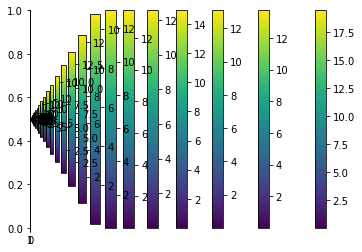

ERROR:tornado.application:Exception in callback <bound method TimerBase._on_timer of <matplotlib.backends.backend_webagg_core.TimerTornado object at 0x7f5091c84520>>
Traceback (most recent call last):
  File "/homes/mzvyagin/anaconda3/envs/fno/lib/python3.9/site-packages/tornado/ioloop.py", line 905, in _run
    return self.callback()
  File "/homes/mzvyagin/anaconda3/envs/fno/lib/python3.9/site-packages/matplotlib/backend_bases.py", line 1216, in _on_timer
    ret = func(*args, **kwargs)
  File "/homes/mzvyagin/anaconda3/envs/fno/lib/python3.9/site-packages/matplotlib/animation.py", line 1477, in _step
    still_going = super()._step(*args)
  File "/homes/mzvyagin/anaconda3/envs/fno/lib/python3.9/site-packages/matplotlib/animation.py", line 1189, in _step
    self._draw_next_frame(framedata, self._blit)
  File "/homes/mzvyagin/anaconda3/envs/fno/lib/python3.9/site-packages/matplotlib/animation.py", line 1208, in _draw_next_frame
    self._draw_frame(framedata)
  File "/homes/mzvyagin/

In [85]:
fig3 = None
ax3 = None
cb1 = None
anim3 = None

In [82]:
%matplotlib inline

/ipykernel_2770642/4230642404.py", line 6, in animate3
    ax3.clear()
AttributeError: 'NoneType' object has no attribute 'clear'
ERROR:tornado.application:Exception in callback <bound method TimerBase._on_timer of <matplotlib.backends.backend_webagg_core.TimerTornado object at 0x7f57c20773a0>>
Traceback (most recent call last):
  File "/homes/mzvyagin/anaconda3/envs/fno/lib/python3.9/site-packages/tornado/ioloop.py", line 905, in _run
    return self.callback()
  File "/homes/mzvyagin/anaconda3/envs/fno/lib/python3.9/site-packages/matplotlib/backend_bases.py", line 1216, in _on_timer
    ret = func(*args, **kwargs)
  File "/homes/mzvyagin/anaconda3/envs/fno/lib/python3.9/site-packages/matplotlib/animation.py", line 1479, in _step
    self._init_draw()
  File "/homes/mzvyagin/anaconda3/envs/fno/lib/python3.9/site-packages/matplotlib/animation.py", line 1753, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/homes/mzvyagin/anaconda3/envs/fno/lib/python3.9/site-pack

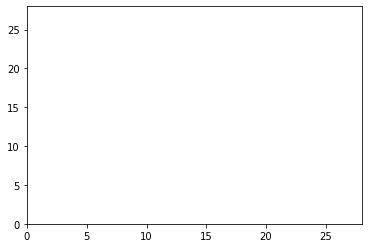

/tmp/ipykernel_2770642/3901750645.py:7: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(im_out)
/tmp/ipykernel_2770642/2574752171.py:8: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(im_out)
ERROR:tornado.application:Exception in callback <bound method TimerBase._on_timer of <matplotlib.backends.backend_webagg_core.TimerTornado object at 0x7f56ec69f4c0>>
Traceback (most recent call last):
  File "/homes/mzvyagin/anaconda3/envs/fno/lib/python3.9/site-packages/tornado/ioloop.py", line 905, in _run
    return self.callback()
  File "/homes/mzvyagin/anaconda3/envs/fno/

In [86]:
fig3 = plt.figure()
ax3 = plt.axes(xlim=(0, 28), ylim=(0, 28))
# cb1 = matplotlib.colorbar.ColorbarBase(ax3)

# def animate3(i):
#     ax3.clear()
#     im_out = ax3.imshow(abs(frames2[i].squeeze().numpy().astype("float32")-frames1[i].squeeze().numpy().astype("float32")))
#     plt.colorbar(im_out)

    
# anim3 = FuncAnimation(fig3, animate3, frames=50, blit=False)
# anim3.save('diff_imshow.mp4', fps=5, extra_args=['-vcodec', 'libx264'])
# plt.show()

In [81]:
ax3

<AxesSubplot:>

In [ ]:
anim.pause()